<div>
<h1> Short Time Fourier Transform</h1> 
</div>


### Missing Time Localization

The Fourier transform yields frequency information that is averaged over the entire time domain. However, the information on **when** these frequencies occur is hidden in the transform. This phenomenon is illustrated by the following example.

In [3]:
import os
import scipy
import numpy as np
import matplotlib
from  matplotlib import pyplot as plt
import librosa
import IPython.display as ipd
%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

In [4]:
Fs = 128
duration = 10
f1 = 1
f2 = 5

N = int(duration*Fs)

t = np.arange(N) / Fs
t1 = t[: N // 2]
t2 = t[N // 2:]

x1 = 1.0 * np.sin(2 * np.pi * f1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * f2 * t2)

x = np.concatenate((x1, x2))

plt.figure(figsize=(15,2))
plt.plot(t, x, c='k')
plt.show()

X = np.abs(np.fft.fft(x))
freq = np.fft.fftfreq(N, d=1/Fs)

X = X[: N // 2]
freq = freq[: N // 2]

plt.figure(figsize=(15,2))
plt.plot(freq, X, c='k')
plt.xlim([0, 7])
plt.show()

NameError: name 'plt' is not defined

### Basic Idea

To recover the hidden time information, Dennis Gabor introduced in the year 1946 the **short-time Fourier transform** (STFT). 

Instead of considering the entire signal, the main idea of the STFT is to consider only a **small section** of the signal. To this end, one fixes a so-called **window function**, which is a function that is nonzero for only a short period of time (defining the considered section). The original signal is then multiplied with the window function to yield a **windowed signal**. To obtain frequency information at different time instances,  one shifts the window function across time and computes a Fourier transform for each of the resulting windowed signals. This idea is illustrated by the next example.

In [5]:
def windowed_ft(t, x, Fs, w_pos_sec, w_len):
    N = len(x)
    w_pos = int(w_pos_sec * Fs)
    w_padded = np.zeros(N)
    w_padded[w_pos : w_pos + w_len ] = 1
    x = x * w_padded
    
    plt.figure(figsize=(15, 2))
    
    plt.subplot(1, 2, 1)
    plt.plot(t, x)
    plt.plot(t, w_padded, c='r')
    
    plt.subplot(1, 2, 2)
    
    X = np.abs(np.fft.fft(x))
    freq = np.fft.fftfreq(N, d=1/Fs)
    
    X = X[: N // 2]
    freq = freq[: N // 2]
    plt.plot(freq, X, c='k')
    plt.xlim([0, 7])
    
    plt.show()

    

In [6]:
w_len = 4 * Fs

windowed_ft(t, x, Fs, w_pos_sec=1, w_len=w_len)
windowed_ft(t, x, Fs, w_pos_sec=3, w_len=w_len)
windowed_ft(t, x, Fs, w_pos_sec=5, w_len=w_len)




NameError: name 'plt' is not defined

It is important to note that the STFT reflects not only the properties of the original signal but also those of the window function. First of all, the STFT depends on the length of the window, which determines the size of the section. 
Then, the STFT is influenced by the shape of the window function. For example, the sharp edges of the rectangular window typically introduce "ripple" artifacts. 

### Formal Definition of the Discrete STFT

We now consider the discrete case of the STFT and specify the most important mathematical formulas as needed in practical applications. 

Let $x:[0:L-1]:=\{0,1,\ldots,L-1\}\to{\mathbb R}$ be a real-valued discrete-time (DT) signal of length $L$ obtained by equidistant sampling with respect to a fixed sampling rate $F_\mathrm{s}$ given in Hertz. 

Furthermore, let $w:[0:N-1]\to\mathbb{R}$ be a sampled  window function of length $N\in\mathbb{N}$. For example, in the case of a rectangular window one has $w(n)=1$ for $n\in[0:N-1]$. The length parameter $N$ determines the duration of the considered sections, which amounts to $N/F_\mathrm{s}$ seconds. One also introduces an additional parameter $H\in\mathbb{N}$, which is referred to as the **hop size**.  The hop size parameter is specified in samples and determines the step size in which the window is to be shifted across the signal. 

With regard to these parameters, the **discrete STFT** $\mathcal{X}$ of the signal $x$ is given by  

\begin{eqnarray}
   \mathcal{X}(m,k):= \sum_{n=0}^{N-1} x(n+mH)w(n)e^{-2\pi ikn/N}
\end{eqnarray} 

with $m\in[0:M]$ and $k\in[0:K]$. The number $M:=\lfloor \frac{L-N}{H} \rfloor$ is the maximal frame index such that the window's time range is fully contained in the signal's time range. Furthermore, $K=N/2$ (assuming that $N$ is even) is the frequency index corresponding to the Nyquist frequency. The complex number $\mathcal{X}(m,k)$ denotes the $k^\text{th}$ Fourier coefficient for the $m^\text{th}$ time frame.  Note that for each fixed time frame $m$, one obtains a **spectral vector** of size $K+1$ given by the coefficients $\mathcal{X}(m,k)$ for $k\in[0:K]$. The computation of each spectral vector amounts to a DFT of size $N$, which can be done efficiently using the FFT.



### Spectrogram

The **spectrogram** is a two-dimensional representation of the squared magnitude of the STFT:

\begin{eqnarray}
    \mathcal{Y}(m,k):= | \mathcal{X}(m,k)|^2.
\end{eqnarray} 

It can be visualized by means of a two-dimensional image, where the horizontal axis represents time and the vertical axis represents frequency. In this image, the spectrogram value $\mathcal{Y}(m,k)$ is represented by the intensity or color in the image at the coordinate $(m,k)$. Note that in the discrete case, the time axis is indexed by the frame indices $m$ and the frequency axis is indexed by the frequency indices $k$.


In [7]:
def stft_basic(x, w, H=8):
    N = len(w)
    L = len(x)
    M = int(np.floor((L - N) / H))
    X = np.zeros((N, M + 1), dtype='complex')
    for m in range(M + 1):
        x_win = x[m * H : m * H + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win
    K = (N + 1) // 2
    X = X[:K, :]
    return X

### Example

As an illustrative example, we consider a recording of a C-major scale played on a piano. In the following figure, the spectrogram representation of the recording is shown, where the time and frequency axes are labeled in a physically meaningful way. Furthermore, the spectrogram is also shown using a logarithmic dB scale (to enhance small sound components that may still be perceptually relevant).

The spectrogram reveals the frequency information of the played notes over time. For each note, one can observe horizontal lines that are stacked on top of each other. These equally spaced lines correspond to the partials, the integer multiples of the fundamental frequency of a note. Obviously, the higher partials contain less and less of the signal's energy. Furthermore, the decay of each note over time is reflected by the fading out of the  horizontal lines.

<img src="img/scale.png" width="300px" align="left" alt="C0">

<br clear="all" />

<audio src="audio/scale.wav" type="audio/mpeg" controls="controls"></audio>



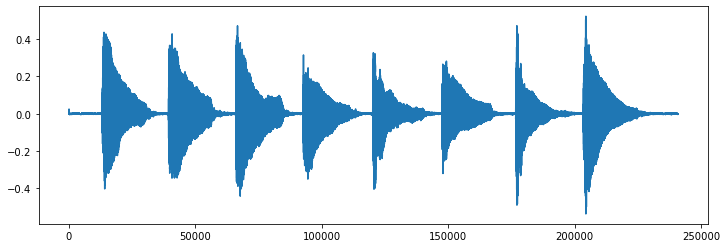

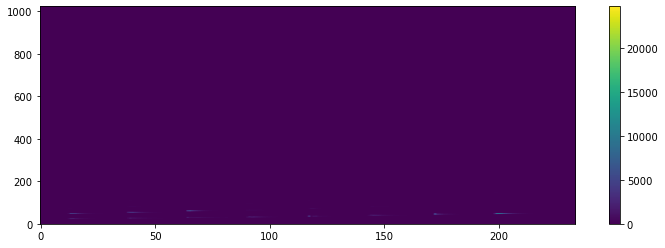

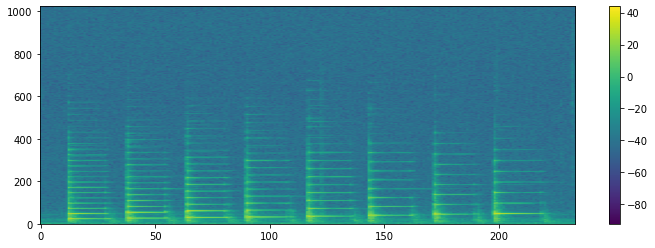

In [36]:
fn_wav = os.path.join('audio', 'scale.wav')
x, Fs = librosa.load(fn_wav)

H = 1024
N = 2048

w = np.hanning(N)
X = stft_basic(x, w, H)

Y = np.abs(X)**2

eps = np.finfo(float).eps
Y_db = 10 * np.log10(Y + eps)

plt.figure(figsize=(12, 4))
plt.plot(x)

plt.figure(figsize=(12, 4))
plt.imshow(Y, origin='lower', aspect='auto')
plt.colorbar()

plt.figure(figsize=(12, 4))
plt.imshow(Y_db, origin='lower', aspect='auto')
plt.colorbar()

In [29]:
X

array([[-8.02150632e-01+0.00000000e+00j,  1.62034064e-01+0.00000000e+00j,
         5.69175966e-01+0.00000000e+00j, ...,
        -4.98286357e-02+0.00000000e+00j,  4.97601218e-02+0.00000000e+00j,
         2.50660894e-01+0.00000000e+00j],
       [ 5.11101029e-01+2.88716589e-01j, -3.38593917e-02+5.21104133e-02j,
        -4.62109688e-01-1.08339703e-01j, ...,
         1.85277238e-01-1.69793758e-01j, -8.10248952e-03+1.43223293e-01j,
        -4.67075121e-02+8.66329827e-02j],
       [-1.21826998e-01-2.22345021e-02j, -9.06491081e-02+1.16403702e-02j,
         2.38644147e-01+6.09354802e-02j, ...,
        -2.74340507e-01-1.47405522e-01j,  6.01623929e-02-4.00827397e-02j,
        -2.41893335e-01-8.53386889e-02j],
       ...,
       [-5.21954888e-03+3.06802061e-04j, -2.48635233e-03-6.42881442e-03j,
        -3.94540584e-04+2.80657535e-03j, ...,
        -3.00627215e-03+4.20285617e-03j,  6.09374841e-03-2.85423305e-04j,
         6.53348129e-03+4.77293472e-03j],
       [-2.26779896e-04-3.71338517e-04j,  6.